## About
The Immigration and Nationality Act (INA) of the US permits foreign workers to come to the United States to work on either a temporary or permanent basis. 
The act also protects US workers against adverse impacts on working place and maintain requirements when they hire foreign workers to fill workforce shortages. The immigration programs are administered by the Office of Foreign Labor Certification (OFLC).

## 1) Problem statement.

* OFLC gives job certification applications for employers seeking to bring foreign workers into the United States and grants certifications. 
* As In last year the count of employees were huge so OFLC needs Machine learning models to shortlist visa applicants based on their previous data.

**In this project we are going to use the data given to build a Classification model:**

* This model is to check if Visa get approved or not based on the given dataset.
* This can be used to Recommend a suitable profile for the applicants for whom the visa should be certified or denied based on the certain criteria which influences the decision.

## 2) Data Collection.
* The Dataset is part of Office of Foreign Labor Certification (OFLC)
* The data consists of 25480 Rows and 12 Columns
* The dataset is from [KAGGLE]<https://www.kaggle.com/datasets/moro23/easyvisa-dataset>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import seaborn as sns
from utils_machine_learning import *

sns.set(style="darkgrid")
sns.set_color_codes("muted")

pd.set_option('future.no_silent_downcasting', True)

In [2]:
# load the dataset
def load_dataset() -> pd.DataFrame:
    """
    Load the dataset from the CSV file and return it as a pandas DataFrame.

    Args:
        None

    Returns:
        pd.DataFrame: The dataset loaded from the CSV file.
    """

    data_path = "EasyVisa.csv"
    data = pd.read_csv(data_path, sep=",")
    return data

In [3]:
data_raw = load_dataset()
data_raw.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [4]:
(data_raw
.shape # The shape of the Dataframe
# .info() # structure and data types
# .duplicated().sum()  # Check for duplicate rows
# .isnull().sum()  # Check for missing values in each column
# .isnull().sum().sum() # Check the total number of missing values
# .y.value_counts() # Counts the unique values of the target column
# .columns  # List column names
# .value_counts(dropna=False)  # Count unique values in each column, including NaN
# .nunique()  # Count unique values in each column (excluding NaN)
# .describe(include=['float', 'int']).T # Summary statistics to detect anomalies
# .select_dtypes(include=['object'])  # Explore selected data type(s)
# .sample(10)
# .head()
)

(25480, 12)

In [5]:
def check_df_with_commentries(dataframe: pd.DataFrame, head: int = 5, check_na: bool = True, target_col='y') -> None:
    """
    Provides a detailed overview of a DataFrame, including its shape, data types, head/tail rows, 
    missing values, and quantiles.

    Parameters:
    ----------
    dataframe : pd.DataFrame
        The DataFrame to be analyzed.
    head : int, optional
        Number of rows to display from the head and tail of the DataFrame (default is 5).
    check_na : bool, optional
        Whether to display missing values information (default is True).

    Returns:
    -------
    None
    """

    try:
        print(f"============= OBSERVATIONS ==============")
        
        dtype_summary = ", ".join([f"{dtype}: {count}" for dtype, count in dataframe.dtypes.value_counts().items()])
        print(f">> The shape of the dataset is {dataframe.shape}, comprising of {dataframe.shape[0]} rows and {dataframe.shape[1]} columns")
        print(f">> The data types have {dtype_summary}")
        print(f">> There are {data_raw.duplicated().sum()} duplicate rows. These duplicate rows have to be deleted")
        print(f">> There are {data_raw.isnull().sum().sum()} null values")
        print(f">> The target column {target_col} has a value of {data_raw[target_col].unique()}")

    except Exception as e:
        print(f"An error occurred while checking the DataFrame: {e}")

In [6]:
check_df_with_commentries(data_raw)

============= OBSERVATIONS ==============
>> The shape of the dataset is (25480, 12), comprising of 25480 rows and 12 columns
>> The data types have object: 9, int64: 2, float64: 1
>> There are 0 duplicate rows. These duplicate rows have to be deleted
>> There are 0 null values
An error occurred while checking the DataFrame: 'y'


In [7]:
data_raw.columns

Index(['case_id', 'continent', 'education_of_employee', 'has_job_experience',
       'requires_job_training', 'no_of_employees', 'yr_of_estab',
       'region_of_employment', 'prevailing_wage', 'unit_of_wage',
       'full_time_position', 'case_status'],
      dtype='object')

In [8]:
data_raw['education_of_employee'].unique()

array(['High School', "Master's", "Bachelor's", 'Doctorate'], dtype=object)

In [9]:
yes_no_map = {"Certified": 1, "Denied": 0}

job_mapping = {
    'High School': 1,
    "Bachelor's": 2, 
    "Master's": 3, 
    "Doctorate": 4
    }

In [10]:
# Define the mapping for yes or no value

data = (data_raw
        #.replace({'job': job_mapping, 'education': education_mapping})
        .assign(case_status=data_raw['case_status'].map(yes_no_map),
                education_of_employee=data_raw['education_of_employee'].map(job_mapping),
                )
        #.replace({'default': yes_no_map, 'housing': yes_no_map, 'loan': yes_no_map})
        #.assign(new_age_cat=lambda df: pd.cut(df['age'], bins=[-np.inf, 35, 55, np.inf], labels=["young", "middleage", "old"]))
        .drop(columns=['case_id'])
        )

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   continent              25480 non-null  object 
 1   education_of_employee  25480 non-null  int64  
 2   has_job_experience     25480 non-null  object 
 3   requires_job_training  25480 non-null  object 
 4   no_of_employees        25480 non-null  int64  
 5   yr_of_estab            25480 non-null  int64  
 6   region_of_employment   25480 non-null  object 
 7   prevailing_wage        25480 non-null  float64
 8   unit_of_wage           25480 non-null  object 
 9   full_time_position     25480 non-null  object 
 10  case_status            25480 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 2.1+ MB


In [12]:
# Calculate the correlation matrix
data.select_dtypes(include=['number']).corr()

,education_of_employee,no_of_employees,yr_of_estab,prevailing_wage,case_status
education_of_employee,1.000000,0.025864,0.000199,0.007835,0.318189
no_of_employees,0.025864,1.000000,-0.017770,-0.009523,0.008677
yr_of_estab,0.000199,-0.017770,1.000000,0.012342,0.008597
prevailing_wage,0.007835,-0.009523,0.012342,1.000000,0.076198
case_status,0.318189,0.008677,0.008597,0.076198,1.000000


In [13]:
# separate the columns into different data dtypes
categorical_cols, numerical_cols, cardinal_cols, nominal_cols = grab_col_names(data)
target_col = 'case_status'

Observations: 25480
Variables: 11
Categorical Columns: 8 -> ['continent', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position', 'education_of_employee', 'case_status']
Numerical Columns: 3 -> ['no_of_employees', 'yr_of_estab', 'prevailing_wage']
Cardinal Columns: 0 -> []
Nominal Columns: 2 -> ['education_of_employee', 'case_status']


               continent      Ratio
continent                          
Asia               16861  66.173469
Europe              3732  14.646782
North America       3292  12.919937
South America        852   3.343799
Africa               551   2.162480
Oceania              192   0.753532
##########################################


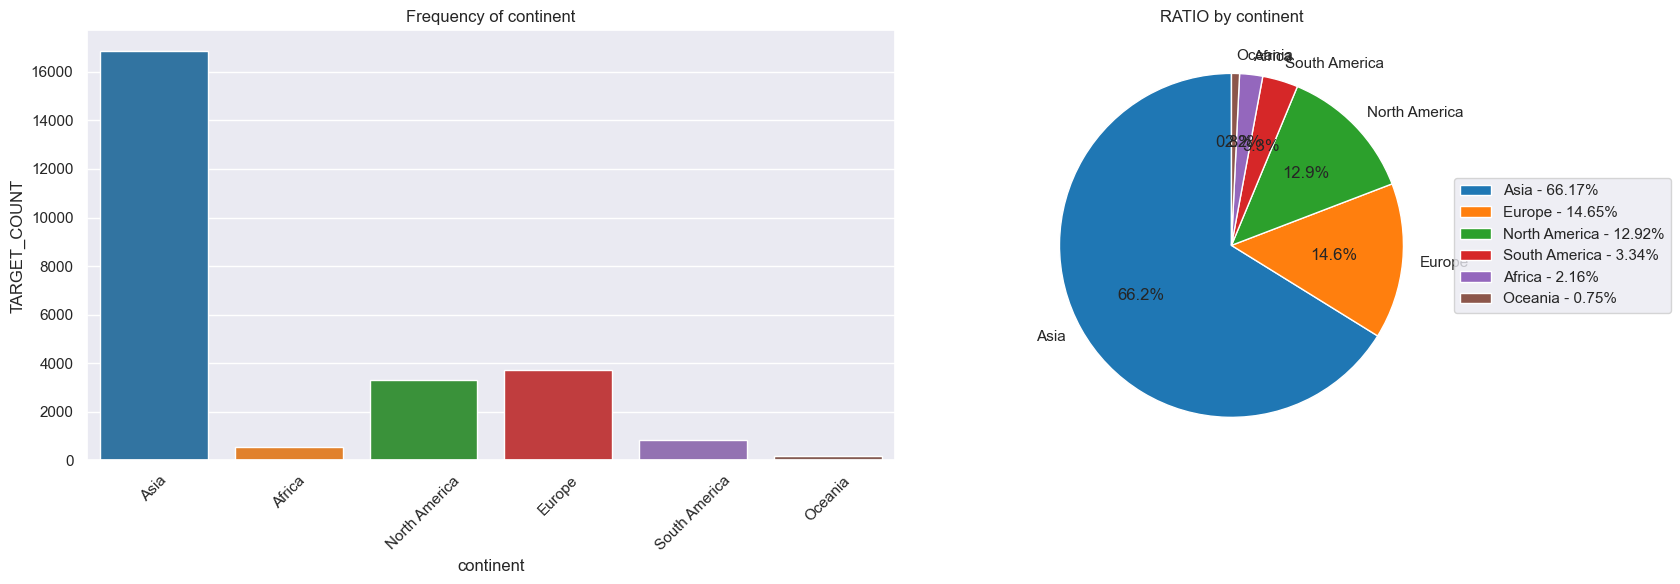

                    has_job_experience      Ratio
has_job_experience                               
Y                                14802  58.092622
N                                10678  41.907378
##########################################


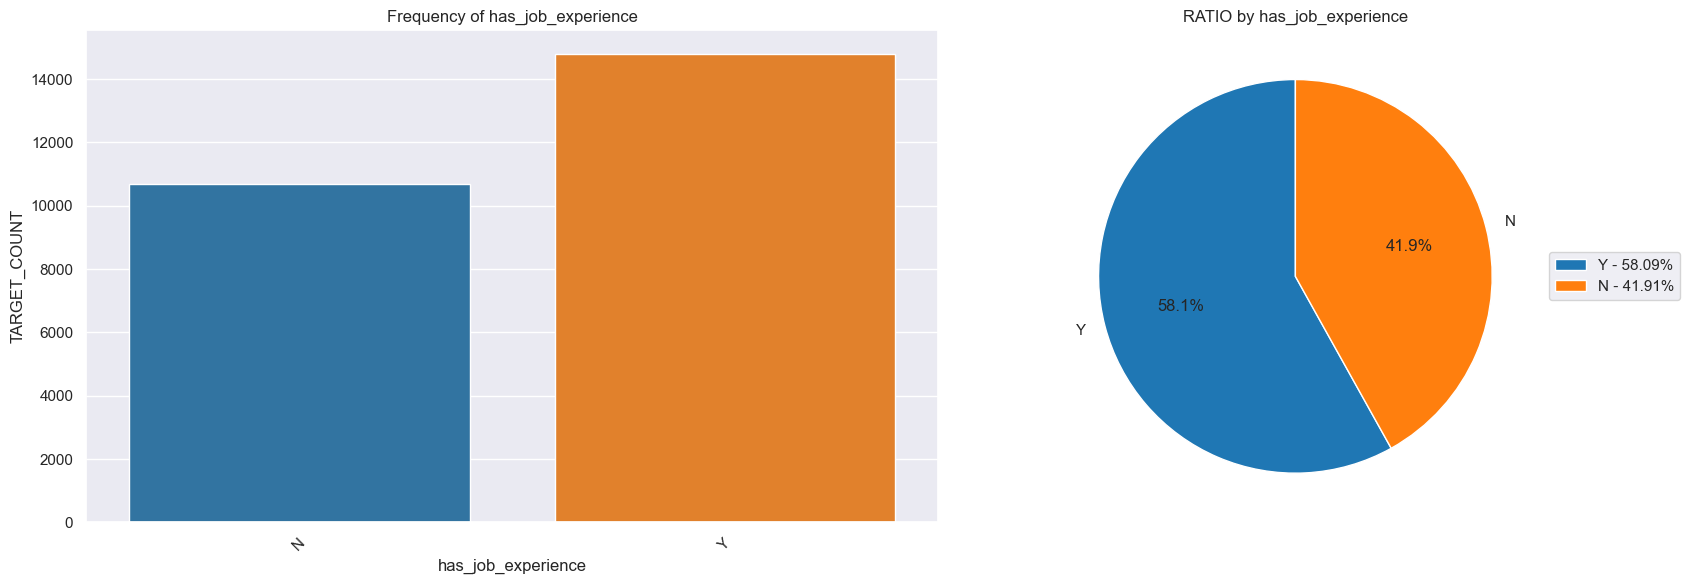

                       requires_job_training      Ratio
requires_job_training                                  
N                                      22525  88.402669
Y                                       2955  11.597331
##########################################


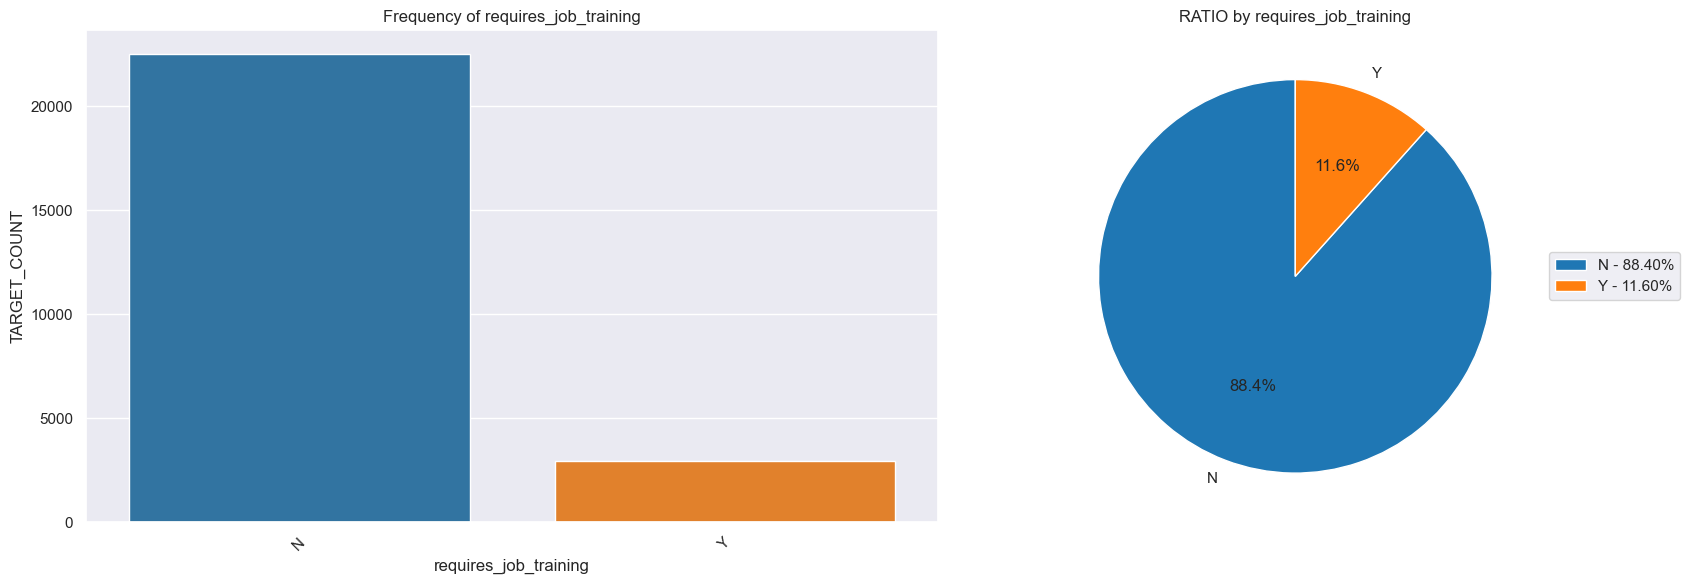

                      region_of_employment      Ratio
region_of_employment                                 
Northeast                             7195  28.237834
South                                 7017  27.539246
West                                  6586  25.847724
Midwest                               4307  16.903454
Island                                 375   1.471743
##########################################


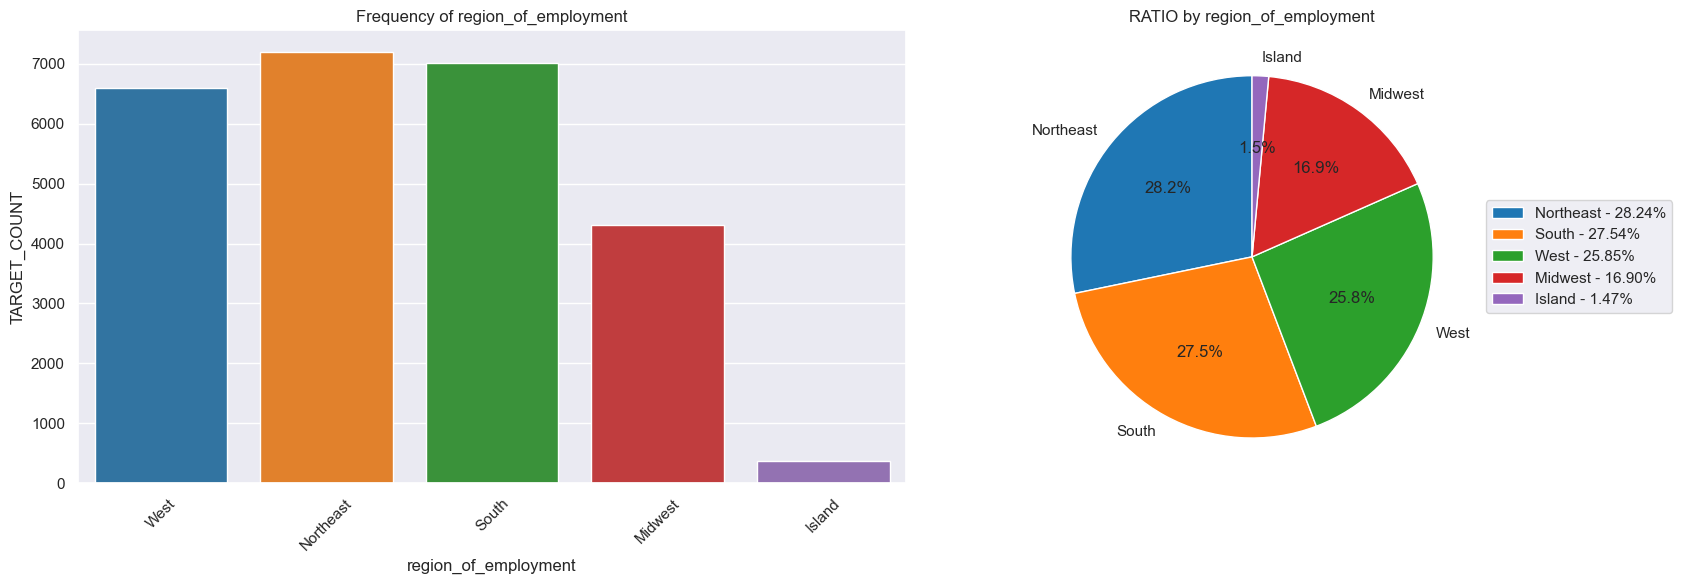

              unit_of_wage      Ratio
unit_of_wage                         
Year                 22962  90.117739
Hour                  2157   8.465463
Week                   272   1.067504
Month                   89   0.349294
##########################################


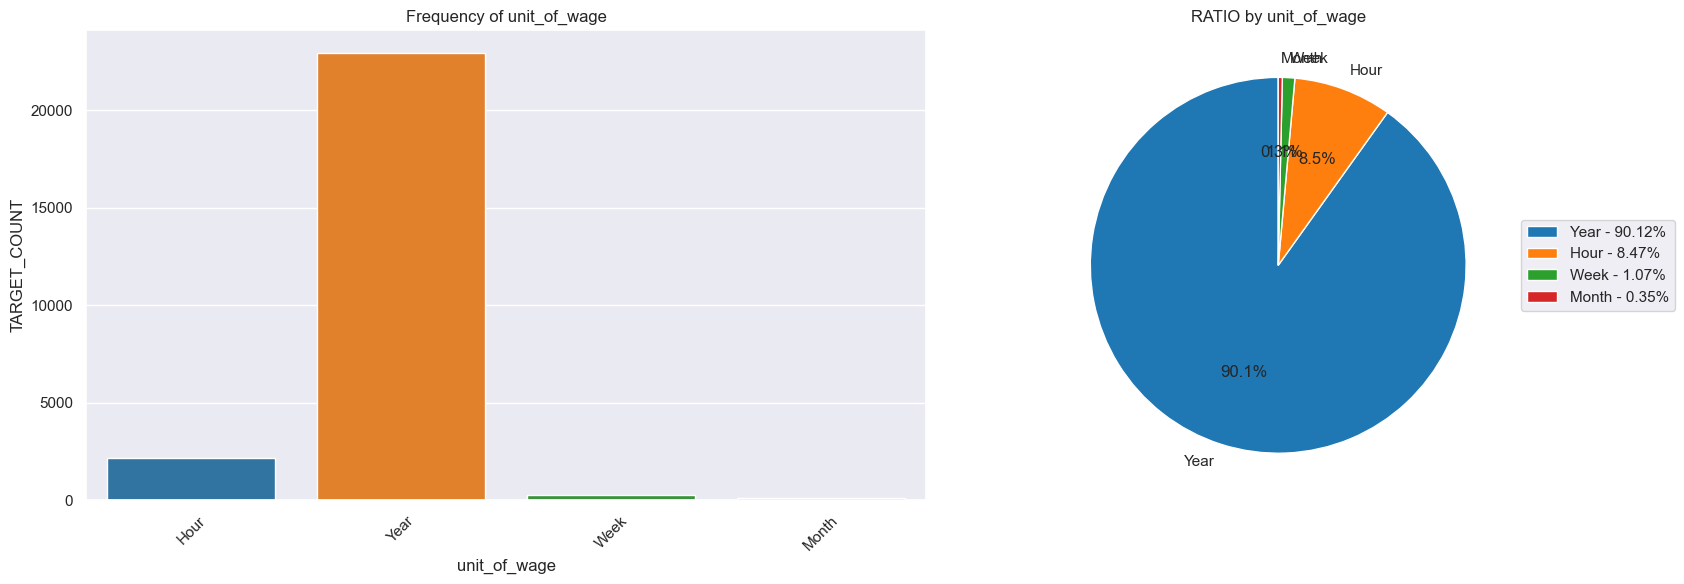

                    full_time_position      Ratio
full_time_position                               
Y                                22773  89.375981
N                                 2707  10.624019
##########################################


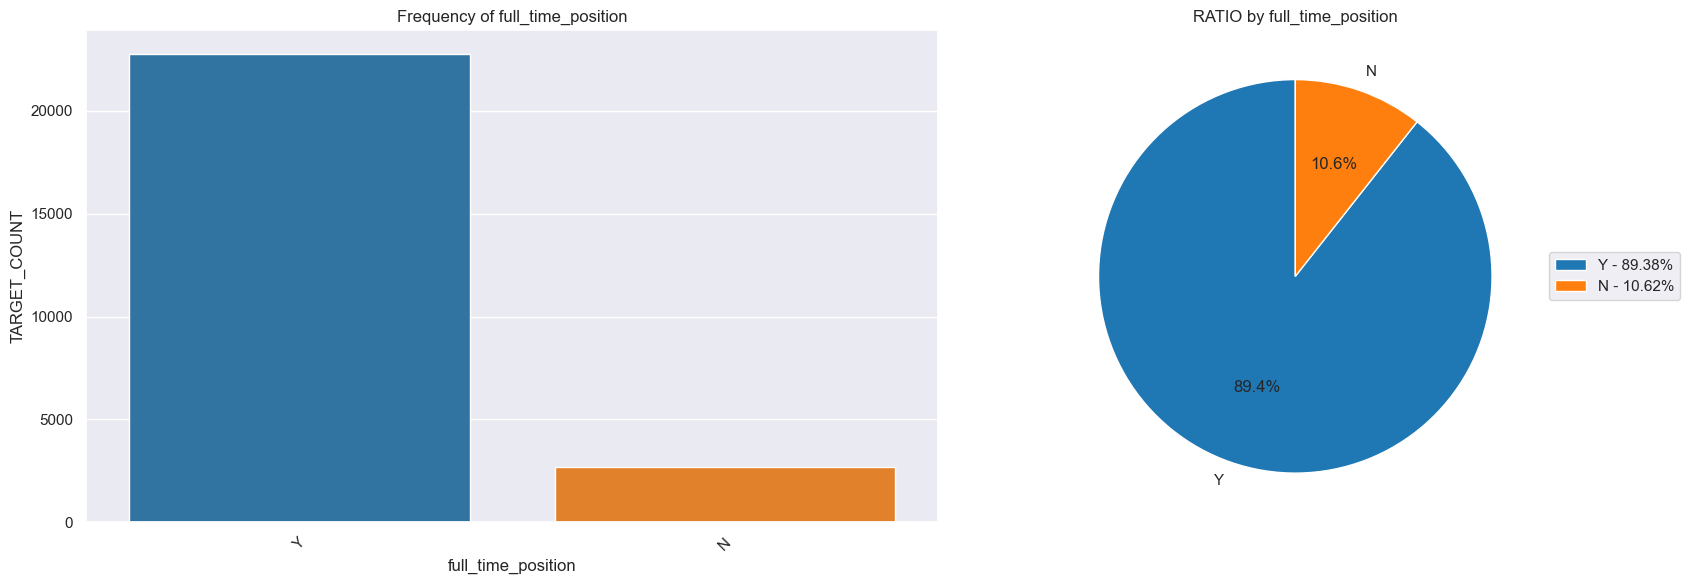

2024-09-25 11:22:23,006 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-25 11:22:23,014 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


                       education_of_employee      Ratio
education_of_employee                                  
2                                      10234  40.164835
3                                       9634  37.810047
1                                       3420  13.422292
4                                       2192   8.602826
##########################################


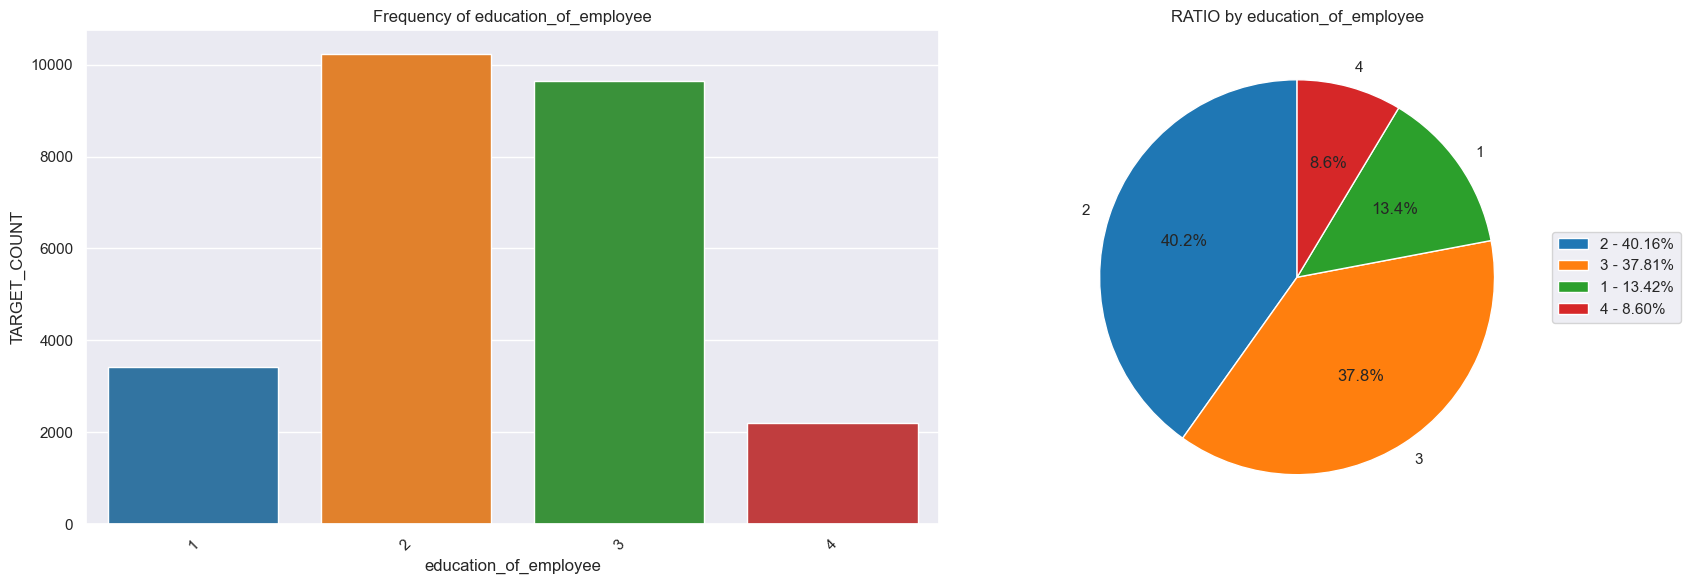

2024-09-25 11:22:23,178 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-25 11:22:23,188 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


             case_status      Ratio
case_status                        
1                  17018  66.789639
0                   8462  33.210361
##########################################


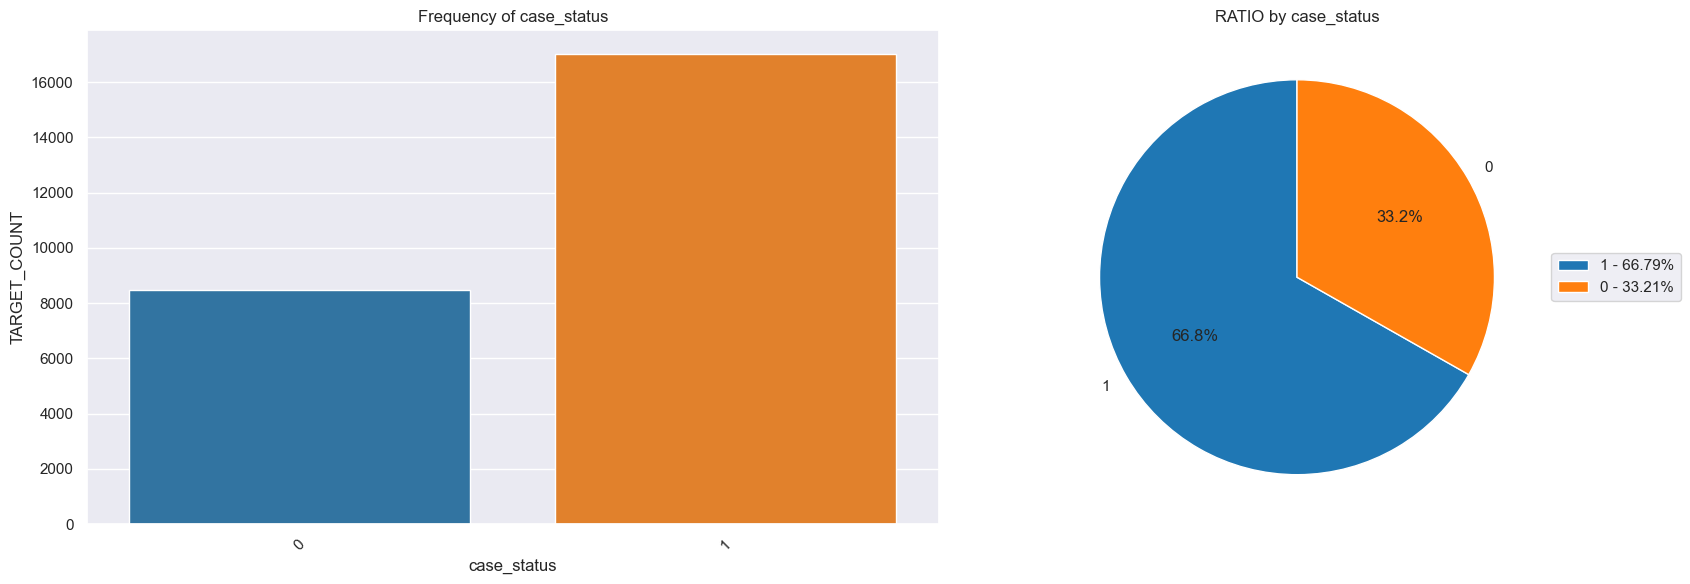

In [14]:
# Examination of categorical variables

for col in categorical_cols:
    cat_summary(data, col,plot=True)

**Insights**
 - `case_id` have unique vlaues for each column which can be dropped as it it of no importance
 - `continent` column is highly biased towards asia. hence we can combine other categories to form a single category.
 - `unit_of_wage` seems to be an important column as most of them are yearly contracts.

In [15]:
data[numerical_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_employees,25480.0,5667.043210,22877.928848,-26.0000,1022.00,2109.00,3504.0000,602069.00
yr_of_estab,25480.0,1979.409929,42.366929,1800.0000,1976.00,1997.00,2005.0000,2016.00
prevailing_wage,25480.0,74455.814592,52815.942327,2.1367,34015.48,70308.21,107735.5125,319210.27


Numerical Column: no_of_employees
##########################################
count     25480.000000
mean       5667.043210
std       22877.928848
min         -26.000000
5%          209.000000
10%         418.000000
20%         815.000000
30%        1236.000000
40%        1666.000000
50%        2109.000000
60%        2597.000000
70%        3171.000000
80%        3899.200000
90%        5069.000000
95%       14083.000000
99%      102767.000000
max      602069.000000
Name: no_of_employees, dtype: float64
##########################################


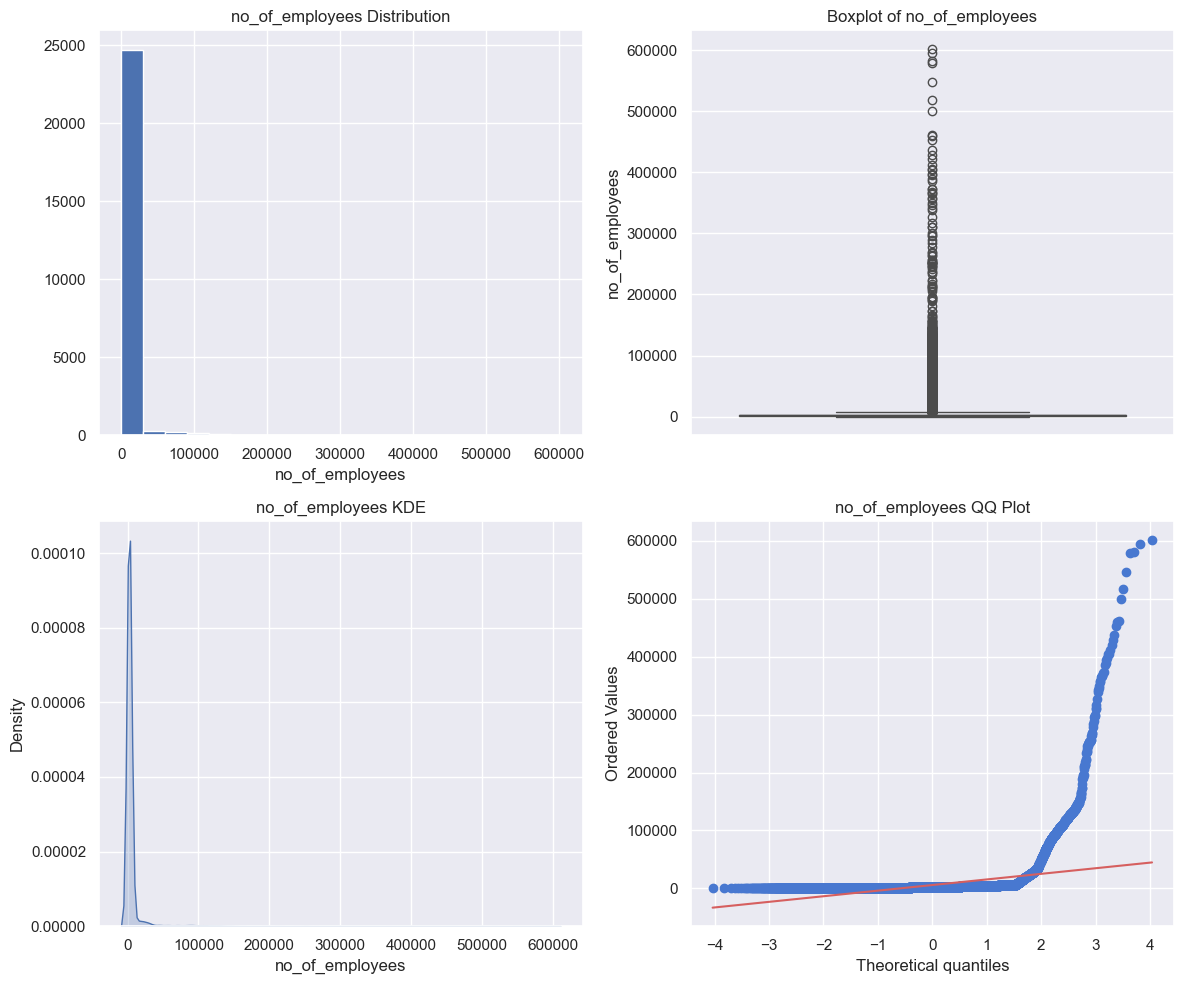

Numerical Column: yr_of_estab
##########################################
count    25480.000000
mean      1979.409929
std         42.366929
min       1800.000000
5%        1872.000000
10%       1911.000000
20%       1966.000000
30%       1982.000000
40%       1991.000000
50%       1997.000000
60%       2000.000000
70%       2003.000000
80%       2006.000000
90%       2009.100000
95%       2012.000000
99%       2014.000000
max       2016.000000
Name: yr_of_estab, dtype: float64
##########################################


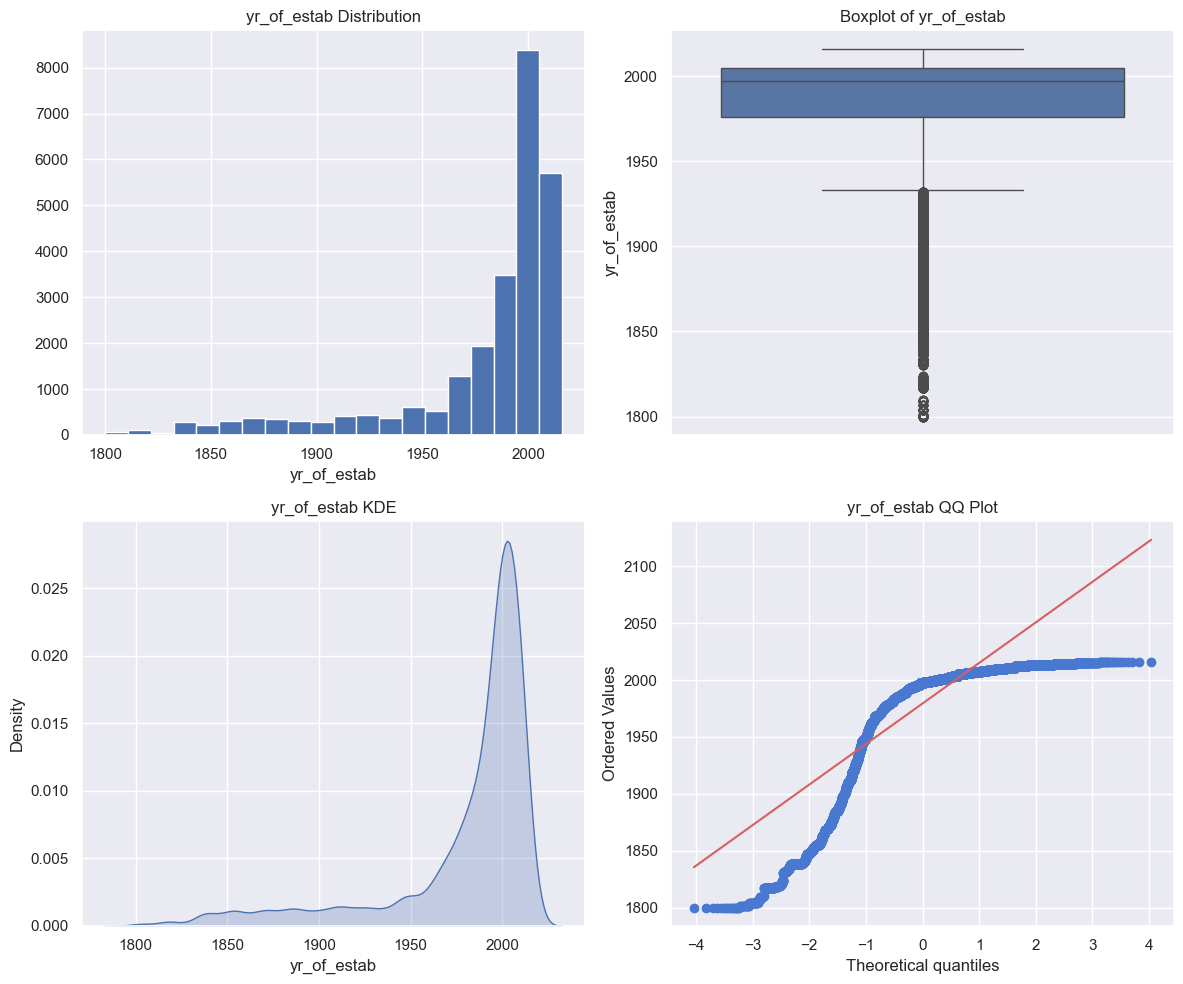

Numerical Column: prevailing_wage
##########################################
count     25480.000000
mean      74455.814592
std       52815.942327
min           2.136700
5%          444.719200
10%        3743.147000
20%       25674.208000
30%       42032.849000
40%       56318.266000
50%       70308.210000
60%       84526.470000
70%       99570.364000
80%      116371.314000
90%      139689.798000
95%      162642.317500
99%      238215.450000
max      319210.270000
Name: prevailing_wage, dtype: float64
##########################################


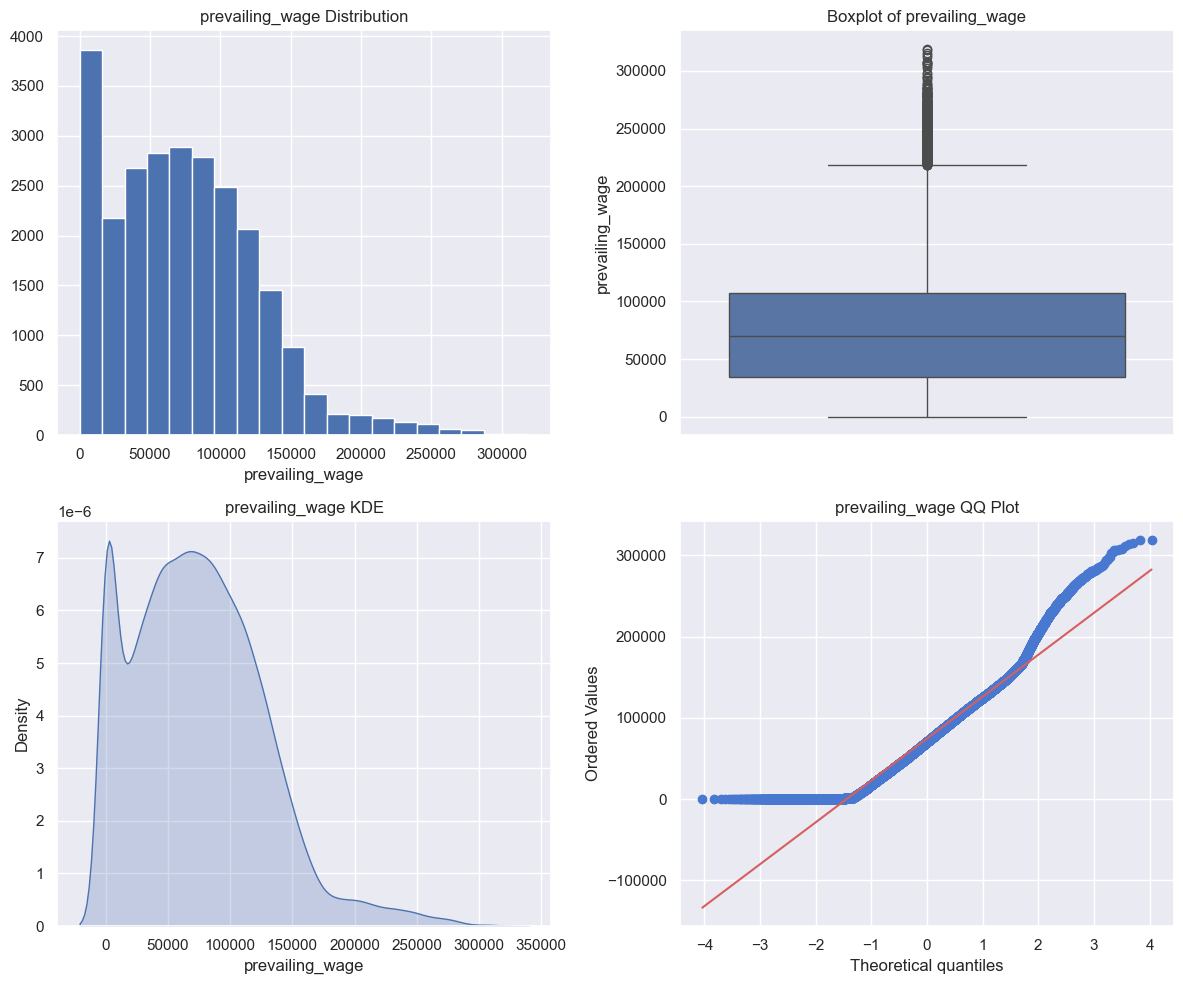

In [16]:
for col in numerical_cols:
    num_summary(dataframe=data,
                numerical_col= col,
                plot= True)

In [17]:
def target_summary_with_num(dataframe, target, numerical_col, bins=None):
    df = dataframe.copy()
    
    # Get summary stats for numerical column grouped by target
    summary_df = df.groupby(target).agg({numerical_col: "mean"})
    
    # If bins is not numeric, calculate appropriate bin edges
    if not isinstance(bins, (int, list)):
        # Automatically determine bin edges using numpy's histogram_bin_edges
        bins = np.histogram_bin_edges(df[numerical_col], bins='auto')
    
    # Bin the numerical column using pd.cut() with calculated bin edges
    df["binned"] = pd.cut(df[numerical_col], bins=bins, include_lowest=True)
    
    # Get summary stats for target grouped by the binned numerical column
    binned_summary_df = df.groupby("binned").agg({target: "mean"}).reset_index()

    return binned_summary_df, summary_df

/var/folders/xh/sd37kh3d117gtcym3lygy3000000gn/T/ipykernel_33686/1837797293.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_summary_df = df.groupby("binned").agg({target: "mean"}).reset_index()
/var/folders/xh/sd37kh3d117gtcym3lygy3000000gn/T/ipykernel_33686/1837797293.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_summary_df = df.groupby("binned").agg({target: "mean"}).reset_index()
/var/folders/xh/sd37kh3d117gtcym3lygy3000000gn/T/ipykernel_33686/1837797293.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pas

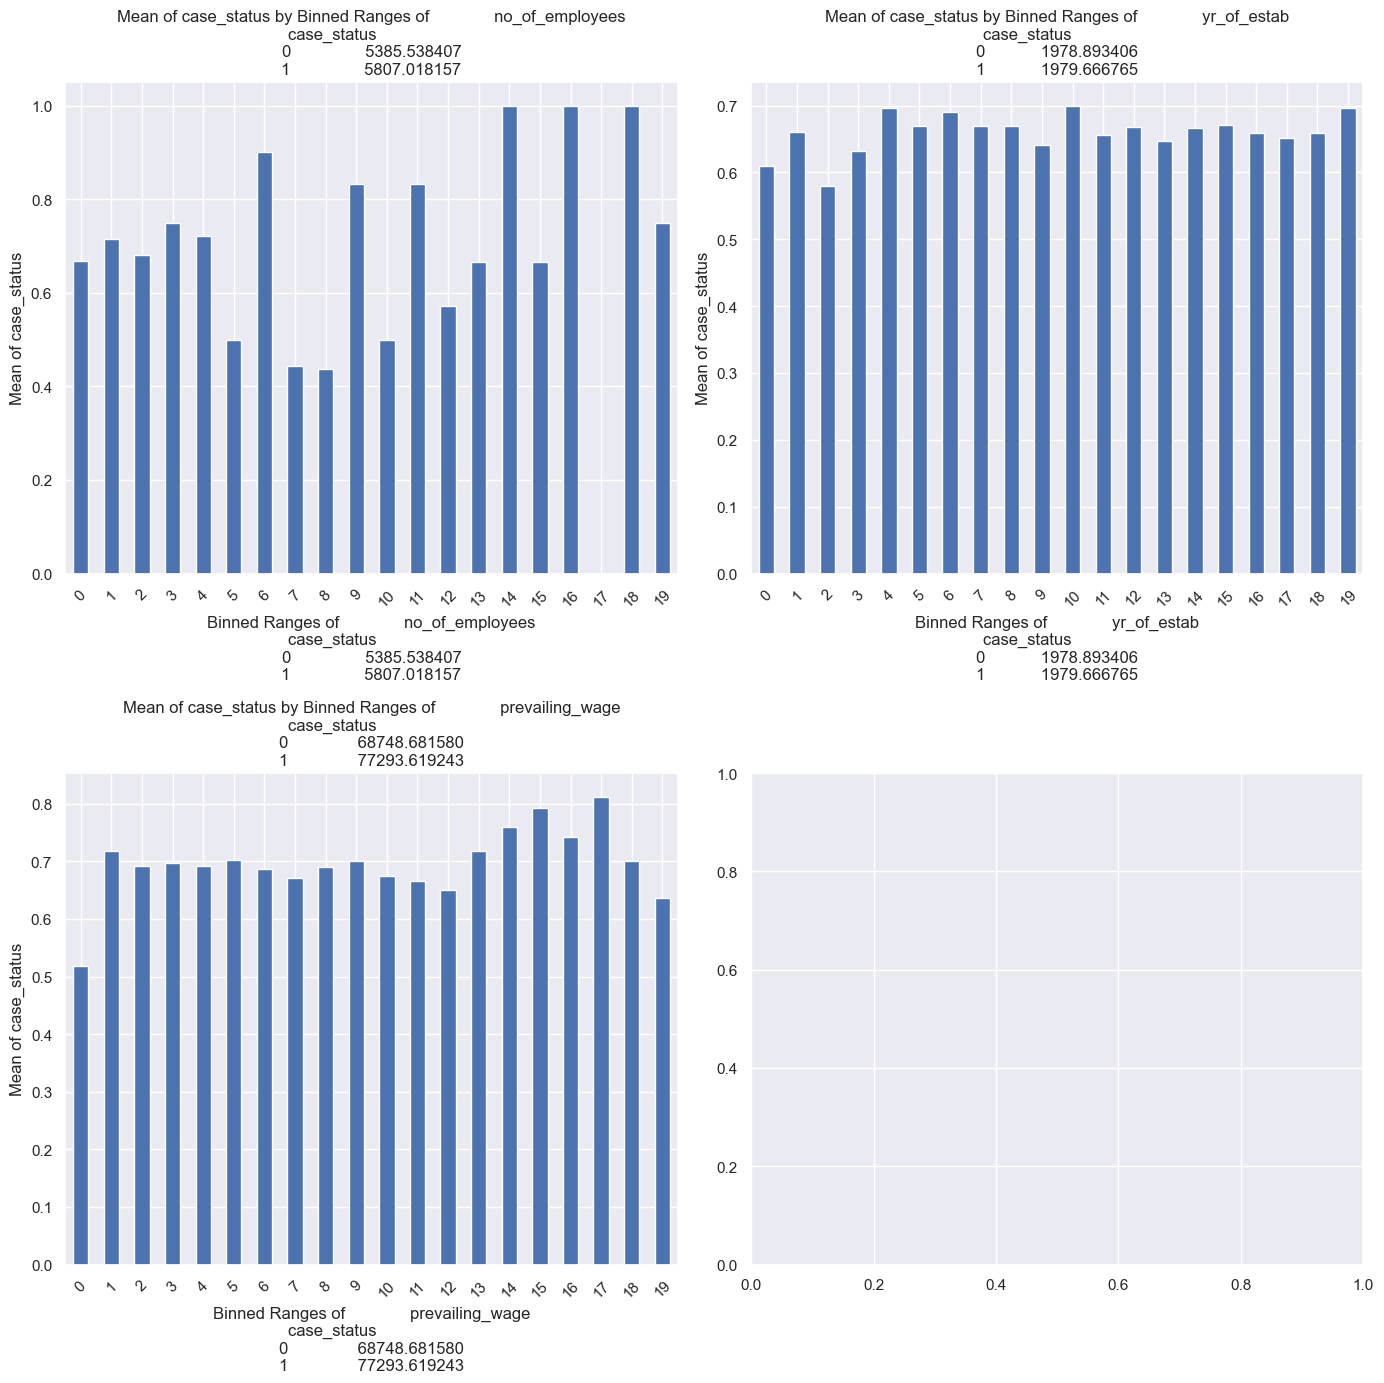

In [18]:
fig, axes = plt.subplots(nrows=(len(numerical_cols) + 1) // 2, ncols=2, figsize=(14, 7 * ((len(numerical_cols) + 1) // 2)))

for idx, col in enumerate(numerical_cols):
    binned_summary_df, col_name = target_summary_with_num(data, target_col, col, bins=20)
    ax = axes[idx // 2, idx % 2]
    binned_summary_df.plot(kind="bar", legend=False, ax=ax)
    ax.set_title(f"Mean of {target_col} by Binned Ranges of {col_name}")
    ax.set_xlabel(f"Binned Ranges of {col_name}")
    ax.set_ylabel(f"Mean of {target_col}")
    ax.set_xticklabels(binned_summary_df.index, rotation=45)

plt.tight_layout()
plt.show()

In [19]:
categorical_features = [col for col in categorical_cols if col != target_col]
numerical_features = [col for col in numerical_cols if col not in categorical_features]

In [20]:
print(f"{categorical_features=}")
print(f"{numerical_features=}")

categorical_features=['continent', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position', 'education_of_employee']
numerical_features=['no_of_employees', 'yr_of_estab', 'prevailing_wage']


2024-09-25 11:22:25,149 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-25 11:22:25,161 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-25 11:22:25,241 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-25 11:22:25,250 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-25 11:22:25,329 - INFO - Using categorical units to plot a list of strings that are all parsable as 

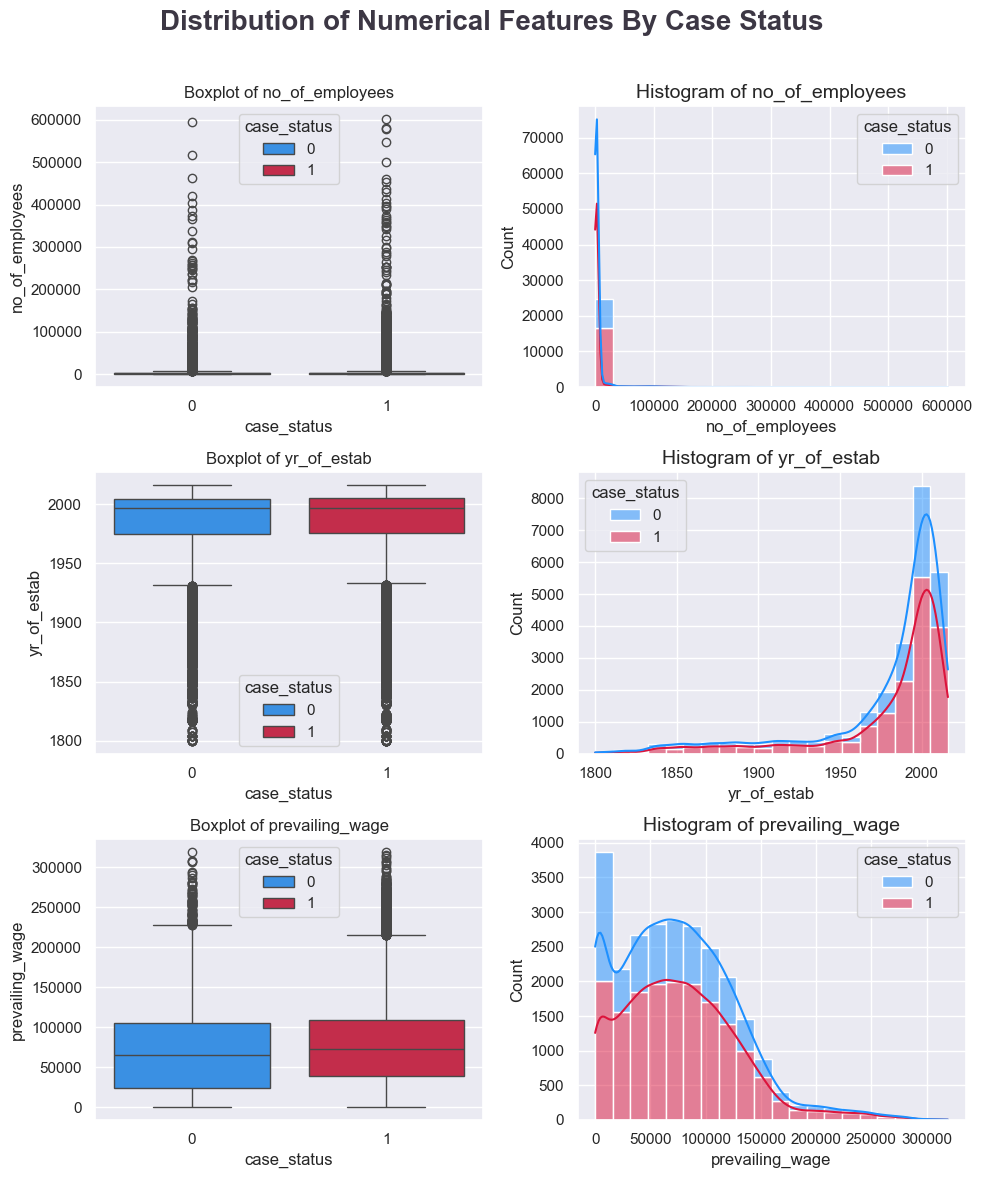

In [21]:
clr1 = ['#1E90FF', '#DC143C']
fig, ax = plt.subplots(3, 2, figsize=(10,12))
fig.suptitle('Distribution of Numerical Features By Case Status', color='#3C3744',
             fontsize=20, fontweight='bold', ha='center')
for i, col in enumerate(numerical_features):   
    sns.boxplot(data=data, x='case_status', y=col,hue='case_status', palette=clr1, ax=ax[i,0])
    ax[i,0].set_title(f'Boxplot of {col}', fontsize=12)
    sns.histplot(data=data, x=col, hue='case_status', bins=20, kde=True, 
                 multiple='stack', palette=clr1, ax=ax[i,1])
    ax[i,1].set_title(f'Histogram of {col}', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.90)
# plt.savefig('images/multivariate_num.png')

### Check Multicollinearity for Categorical features

* **A chi-squared test (also chi-square or χ2 test) is a statistical hypothesis test that is valid to perform when the test statistic is chi-squared distributed under the null hypothesis, specifically Pearson's chi-squared test**

* **A chi-square statistic is one way to show a relationship between two categorical variables.**

* **Here we test correlation of Categorical columns with Target column i.e case_status**

Null Hypothesis ($ H_0 $): The Feature is independent of target column (No-Correlation)

Alternative Hypothesis ($ H_1 $): The Feature and Target column are not independent (Correalted)

In [22]:
from scipy.stats import chi2_contingency
chi2_test = []
for feature in categorical_features:
   if chi2_contingency(pd.crosstab(data['case_status'], data[feature]))[1] < 0.05:
       chi2_test.append('Reject Null Hypothesis')
   else:
       chi2_test.append('Fail to Reject Null Hypothesis')
result = pd.DataFrame(data=[categorical_features, chi2_test]).T
result.columns = ['Column', 'Hypothesis Result']
result

,Column,Hypothesis Result
0,continent,Reject Null Hypothesis
1,has_job_experience,Reject Null Hypothesis
2,requires_job_training,Fail to Reject Null Hypothesis
3,region_of_employment,Reject Null Hypothesis
4,unit_of_wage,Reject Null Hypothesis
5,full_time_position,Reject Null Hypothesis
6,education_of_employee,Reject Null Hypothesis


In [23]:
target_summary_with_categorical_data(data, target_col, 'continent')

               TARGET_MEAN
continent                 
Africa            0.720508
Asia              0.653105
Europe            0.792337
North America     0.618773
Oceania           0.635417
South America     0.578638




/Users/donadviser/github-projects/mlops-production-ready-machine-learning-classification/notebooks/utils_machine_learning.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  s = sns.barplot(ax=ax2, x = feature, y=target, order=cat_perc[feature], data=cat_perc, palette="rocket")


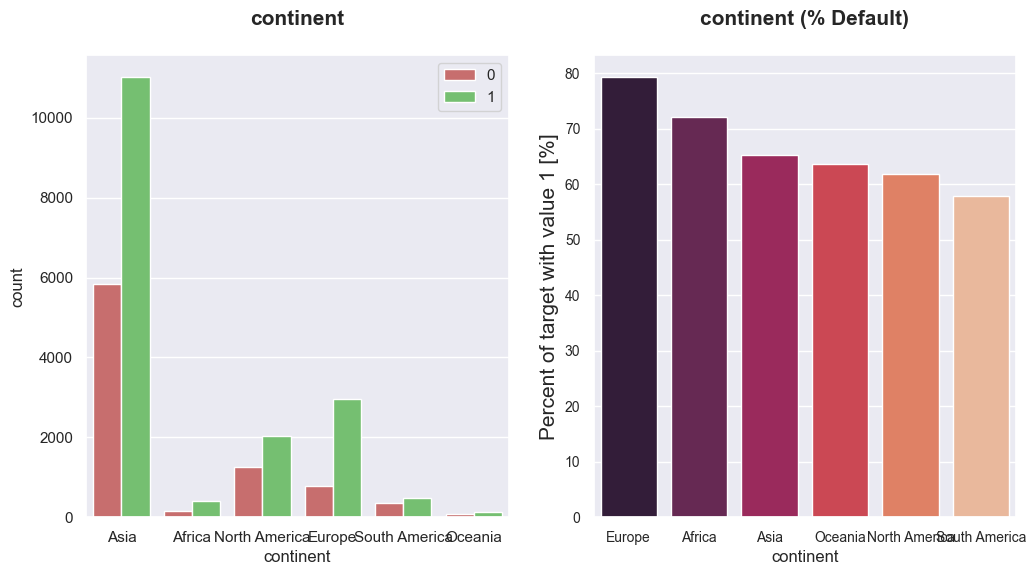

,continent,Number of Count
0,Asia,16861
1,Europe,3732
2,North America,3292
3,South America,852
4,Africa,551
5,Oceania,192


(None, None)

In [24]:
plot_stats('continent', target_col, data, label_rotation=False, horizontal_layout=True)

## Initial Analysis Report

* **No of Employees has many outliers which can be Handled in Feature Engineering and `no_of_employees` is Right Skewed.**
* **`yr_of_estab` is left skewed and some outliers below the lower bound of Box plot.**
* **`prevailing_wage` is right skewed with outliers above upper bound of box plot.**
* **There are No missing values in the dataset.**
* **The `case_id` column can be deleted because each row has unique values.**
* **The `case_status` column is the target to predict.**
* **In the Categorical column, features can be made Binary numerical in feature Encoding**

## Model Training Evaluation

* Split the data into training and testing sets.
* Train the model on the training set and 
* Evaluate its performance on the testing set using metrics like accuracy, precision, recall, F1-score, and AUC ROC.

In [25]:

# Parameters
use_other_modules = False
stratify_target = True

test_size = 0.2
param_grid_flag = False
scoring_metric = "accuracy"
stratify_target = False

In [26]:
from sklearn.model_selection import train_test_split
# Split data into features and target

X = data.drop(columns=[target_col])
y = data[target_col]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                  stratify=y if stratify_target else None,
                                                  random_state=42)

print(f"{X_train.shape=}")
print(f"{y_train.shape=}")
print(f"{X_test.shape=}")

X_train.shape=(20384, 10)
y_train.shape=(20384,)
X_test.shape=(5096, 10)


In [27]:
y.unique()

array([0, 1])

In [28]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler,LabelEncoder, MinMaxScaler, MaxAbsScaler, RobustScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier 

from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier, 
    VotingClassifier, 
    AdaBoostClassifier
    )

from sklearn.model_selection import cross_validate, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix
    )

In [36]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix
    )
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from joblib import dump
import time
import pandas as pd

from imblearn.combine import SMOTETomek, SMOTEENN



In [37]:
def train_and_evaluate_classifiers(X, y, classifiers, test_size=0.2, random_state=42, cv=5, 
                                   grid_search_params=None, use_cross_validation=True, 
                                   use_grid_search=False, use_imbalance_handling=False, 
                                   save_preprocessor=True, return_best_model=True):
    """
    Trains and evaluates multiple classifiers on a given dataset.
    
    Args:
        X (pd.DataFrame): Feature matrix.
        y (pd.Series): Target vector.
        classifiers (dict): A dictionary of classifier names and their respective class instances.
        test_size (float): Proportion of data to use for testing.
        random_state (int): Random seed for reproducibility.
        cv (int): Number of folds for cross-validation.
        grid_search_params (dict): A dictionary of grid search parameters for each classifier (optional).
        use_cross_validation (bool): If True, perform cross-validation.
        use_grid_search (bool): If True, perform grid search for hyperparameter optimisation.
        use_imbalance_handling (bool): If True, apply SMOTE and RandomUnderSampler for imbalance handling.
        save_preprocessor (bool): If True, save the preprocessor to a file.
        return_best_model (bool): If True, return the best model.

    Returns:
        pd.DataFrame: A DataFrame of evaluation results.
        pipeline: The best model's pipeline (if return_best_model is True).
        dict: A dictionary of the trained models.
    """
    
    

    # Preprocessing pipelines
    #numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    #categorical_features = X.select_dtypes(include=['object']).columns

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])  
    
    numerical_transformer = Pipeline(steps=[
        ('skewness', PowerTransformer(method='yeo-johnson'))
    ])      

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features),
            ('num', numerical_transformer, numerical_features)
        ])
    
    
    print(f"{categorical_features=}")
    print(f"{numerical_features=}")
    
    X = preprocessor.fit_transform(X)
    
    if use_imbalance_handling:
        # Resampling the minority class. The strategy can be changed as required.
        smt = SMOTEENN(random_state=42,sampling_strategy='minority' )
        # Fit the model to generate the data.
        X_res, y_res = smt.fit_resample(X, y)

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=test_size, random_state=random_state)
    else:
         # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
        
    
    # Get the all the feature names for feature importance analysis
    all_feature_names = pd.DataFrame(preprocessor.fit_transform(X_train), 
                            columns=preprocessor.get_feature_names_out(), 
                            index=X_train.index)
    feature_names = all_feature_names.columns.tolist()
    
    # Optionally handle class imbalance using SMOTE and RandomUnderSampler
    #if use_imbalance_handling:
    #
    # oversample = SMOTE(k_neighbors=3, sampling_strategy=0.3, random_state=random_state)
        #undersample = RandomUnderSampler(sampling_strategy=0.5, random_state=random_state)
        
        
    
    # Train and evaluate each classifier
    results = []
    best_model = None
    best_models = {}
    best_score = 0

    classifer_results = {}
    
    for classifier_name, classifier in classifiers.items():
        print(f"\nTraining {classifier_name}...")
        
        # Build pipeline
        if use_imbalance_handling:
            #steps = [('preprocessor', preprocessor), ('over', oversample), ('under', undersample), ('classifier', classifier)]
            steps = [('preprocessor', preprocessor), ('over', oversample), ('classifier', classifier)]
            
            pipeline = ImbPipeline(steps=steps)
        else:
            steps = [('preprocessor', preprocessor), ('classifier', classifier)]
            pipeline = Pipeline(steps=steps)
        
        # Cross-validation or Grid Search
        start_time = time.time()
        if use_grid_search and grid_search_params and classifier_name in grid_search_params:
            print(f"Optimising {classifier_name} with GridSearchCV...")
            grid_search = GridSearchCV(pipeline, grid_search_params[classifier_name], cv=cv, scoring='f1')
            grid_search.fit(X_train, y_train)
            pipeline = grid_search.best_estimator_  # Use the best estimator from GridSearchCV
            fit_time = time.time() - start_time
            cv_scores = None  # No need for separate cross-validation scores when grid search is used
            best_estimator = pipeline
        
        elif use_cross_validation:
            print(f"Performing Cross-Validation for {classifier_name}...")
            cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1')
            fit_time = time.time() - start_time
            best_estimator = pipeline
            pipeline.fit(X_train, y_train)
        else:
            print(f"Fitting {classifier_name} without Cross-Validation...")
            best_estimator = pipeline
            pipeline.fit(X_train, y_train)
            fit_time = time.time() - start_time
            cv_scores = None  # No cross-validation scores in this case

        # Evaluate on the test set
        y_pred = pipeline.predict(X_test)

        # Get predicted probabilities
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        # Generate confusion matrix
        confusion_mat = confusion_matrix(y_test, y_pred)

        # Append evaluation results
        results.append({
            'Classifier': classifier_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC AUC': roc_auc,
            'CV F1-Score': cv_scores.mean() if cv_scores is not None else None,
            'Fit Time (s)': fit_time
        })

        # Update best model if necessary
        if use_cross_validation and cv_scores is not None and cv_scores.mean() > best_score:
            best_model = pipeline
            best_score = cv_scores.mean()
        elif not use_cross_validation and f1 > best_score:
            best_model = pipeline
            best_score = f1
        elif f1 > best_score:
            best_model = pipeline
            best_score = f1
        
        # Store the trained model
        best_models[classifier_name] = pipeline

        #print(f"best_model: {best_model}")

        test_scores = score_classifier(y_test, y_pred, fit_time=fit_time)
        classifer_results[classifier_name] = test_scores
            
    
        y_pred = best_model.predict(X_test)
        mat_values_dict = plot_confusion_matrix(confusion_mat, title=f"Confusion Matrix: {classifier_name}")
        classifer_results[classifier_name].update(mat_values_dict)


        auc_score = plot_roc_auc_curve_seaborn(y_test, y_pred_proba, title=f"ROC Curve: {classifier_name}")
        classifer_results[classifier_name].update(auc_score)
        
        important_features = True
        if important_features:
            get_feature_importance_scores(best_estimator=best_estimator, estimator_name='classifier', feature_names=feature_names, n_top_features=10)
         

    # Create a DataFrame of the results
    results_df = pd.DataFrame(results)

    classifer_results_df = pd.DataFrame(classifer_results).T
    
    # Save the best model and preprocessor (if required)
    if save_preprocessor and best_model:
        dump(preprocessor, 'preprocessor.joblib')
        dump(best_model, 'best_classifier.joblib')
        print(f"Best model saved as 'best_classifier.joblib'.")

    # Return results and the best model
    if return_best_model:
        return results_df, best_model, best_models, classifer_results_df
    else:
        return results_df, None, best_models, classifer_results_df

In [31]:
# Define classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    #'LightGBM': LGBMClassifier( random_state=42),
    'XGBoost': XGBClassifier( random_state=42),
    'CatBoost': CatBoostClassifier( verbose=0, random_state=42)
}


In [32]:
# Example grid search parameters (optional)
grid_search_params = {
    'Logistic Regression': {'classifier__C': [0.01, 0.1, 1, 10]},
    'Random Forest': {'classifier__n_estimators': [50, 100, 200], 'classifier__max_depth': [5, 10, 20]},
    'Gradient Boosting': {'classifier__n_estimators': [50, 100, 200], 'classifier__learning_rate': [0.01, 0.1, 0.2]},
    'LightGBM': {'classifier__n_estimators': [50, 100, 200], 'classifier__learning_rate': [0.01, 0.1, 0.2]},
    'XGBoost': {'classifier__n_estimators': [50, 100, 200], 'classifier__learning_rate': [0.01, 0.1, 0.2]},
    'CatBoost': {'classifier__iterations': [50, 100, 200], 'classifier__learning_rate': [0.01, 0.1, 0.2]}
}

In [38]:
# Train and evaluate
results_df, best_model, trained_models, classifer_results_df = train_and_evaluate_classifiers(X, y, classifiers, 
                                                                       use_cross_validation=True, 
                                                                       use_grid_search=True, 
                                                                       grid_search_params=grid_search_params, 
                                                                       use_imbalance_handling=True)

categorical_features=['continent', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position', 'education_of_employee']
numerical_features=['no_of_employees', 'yr_of_estab', 'prevailing_wage']


/Users/donadviser/.pyenv/versions/3.11.10/envs/venv311_usvisa/lib/python3.11/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/donadviser/.pyenv/versions/3.11.10/envs/venv311_usvisa/lib/python3.11/site-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


ValueError: Specifying the columns using strings is only supported for dataframes.

In [ ]:
results_df

In [ ]:
trained_models['Logistic Regression']

In [ ]:
best_classifier = results_df['F1-Score'].idxmax()
best_classifier

In [ ]:
classifer_name_test = 'Logistic Regression'

model = trained_models[classifer_name_test]
y_pred = model.predict(X_test)

predict_vs_actual_df = pd.DataFrame({"Predicted": y_pred, "Actual": y_test})

predict_vs_actual_df.sample(10)

## Feature Encoding and Scaling

**One Hot Encoding for Columns which had lesser unique values and not ordinal**
* One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

**Ordinal Encoding for Columns which has many unique categories** 
* Ordinal encoding is used here as label encoder is supported for column transformer.
* Ordinal encoding is used for Ordinal Variable. Variable comprises a finite set of discrete values with a ranked ordering between values.

**Standard Scaler** 
* Standardize features by removing the mean and scaling to unit variance.

**Power Transformer**
* Power transforms are a technique for transforming numerical input or output variables to have a Gaussian or more-Gaussian-like probability distribution.

In [47]:
transformable_features = ['no_of_employees']
categorical_features = [col for col in categorical_cols if col != target_col]
numerical_features = [col for col in numerical_cols if col not in set(categorical_features + transformable_features)]

In [48]:
print(f"{transformable_features=}")
print(f"{categorical_features=}")
print(f"{numerical_features=}")

transformable_features=['no_of_employees']
categorical_features=['continent', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position', 'education_of_employee']
numerical_features=['yr_of_estab', 'prevailing_wage']


In [49]:
numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()
ordinal_encoder = OrdinalEncoder()
transform_pipe = PowerTransformer(method='yeo-johnson')

In [50]:
preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, categorical_features),
        #("Ordinal_Encoder", ordinal_encoder, or_columns),
        ("Transformer", transform_pipe, transformable_features),
        ("StandardScaler", numeric_transformer, numerical_features)
    ]
)

In [51]:
X = data.drop(columns = target_col)
y = data[target_col]

In [52]:
X = preprocessor.fit_transform(X)

In [54]:
X

array([[ 0.        ,  1.        ,  0.        , ...,  1.51729976,
         0.65122993, -1.39853722],
       [ 0.        ,  1.        ,  0.        , ...,  0.03091211,
         0.53321103,  0.1698353 ],
       [ 0.        ,  1.        ,  0.        , ...,  2.88507606,
         0.6748337 ,  0.91907852],
       ...,
       [ 0.        ,  1.        ,  0.        , ..., -0.41388512,
        -1.63833662,  1.36027953],
       [ 0.        ,  1.        ,  0.        , ..., -0.11194883,
        -2.18122353,  0.22150859],
       [ 0.        ,  1.        ,  0.        , ...,  0.21874168,
        -0.45814768, -0.06776315]])

# Classification

In [55]:
from imblearn.combine import SMOTETomek, SMOTEENN

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTEENN(random_state=42,sampling_strategy='minority' )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X, y)

In [56]:
from sklearn.model_selection import  train_test_split
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((13710, 28), (3428, 28))

In [57]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve 
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [66]:
def evaluate_clf(true, predicted):
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [67]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
     "Support Vector Classifier": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier()

}

In [68]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    models_list = []
    accuracy_list = []
    auc= []
    results_train = []
    results_test = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])
        
        
        # Append evaluation train results
        results_train.append({
            'Classifier': list(models.keys())[i],
            'Accuracy': model_train_accuracy,
            'Precision': model_train_precision,
            'Recall': model_train_recall,
            'F1-Score': model_train_f1,
            'ROC AUC': model_train_rocauc_score,
        })
        
        # Append evaluation text results
        results_test.append({
            'Classifier': list(models.keys())[i],
            'Accuracy': model_test_accuracy,
            'Precision': model_test_precision,
            'Recall': model_test_recall,
            'F1-Score': model_test_f1,
            'ROC AUC': model_test_rocauc_score,
        })
        

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        accuracy_list.append(model_test_accuracy)
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        auc.append(model_test_rocauc_score)
        print('='*35)
        print('\n')
            
    return results_train, results_test

## Model Training 

In [69]:
results_train, results_test = evaluate_models(X=X_res, y=y_res, models=models)

Random Forest
Model performance for Training set
- Accuracy: 0.9999
- F1 score: 0.9999
- Precision: 1.0000
- Recall: 0.9998
- Roc Auc Score: 0.9999
----------------------------------
Model performance for Test set
- Accuracy: 0.9600
- F1 score: 0.9557
- Precision: 0.9623
- Recall: 0.9493
- Roc Auc Score: 0.9591


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9317
- F1 score: 0.9243
- Precision: 0.9316
- Recall: 0.9172
- Roc Auc Score: 0.9305


Gradient Boosting
Model performance for Training set
- Accuracy: 0.8849
- F1 score: 0.8772
- Precision: 0.8668
- Recall: 0.8878
- Roc Auc Score: 0.8851
----------------------------------
Model performance for Test set
- Accuracy: 0.8854
- F1 score: 0.8758
- Precision: 0.8629
- Recall: 0.8890
- Roc Auc Score: 0.8857


Logistic Regression
Model performance for Training 

/Users/donadviser/.pyenv/versions/3.11.10/envs/venv311_usvisa/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Classifier
Model performance for Training set
- Accuracy: 0.8555
- F1 score: 0.8455
- Precision: 0.8372
- Recall: 0.8539
- Roc Auc Score: 0.8554
----------------------------------
Model performance for Test set
- Accuracy: 0.8576
- F1 score: 0.8446
- Precision: 0.8382
- Recall: 0.8511
- Roc Auc Score: 0.8571




In [70]:
# Create a DataFrame of the results
results_test_df = pd.DataFrame(results_test)


In [78]:
to_5_classifer = list(results_test_df.sort_values(by='F1-Score', ascending=False).head(5)['Classifier'])

In [79]:
to_5_classifer

['Random Forest',
 'K-Neighbors Classifier',
 'CatBoosting Classifier',
 'Decision Tree',
 'XGBClassifier']

**Here we can use to 5 classifer for Hyper Parameter Tuning**

**Define the parameter distribution for Random forest**

In [89]:
#Initialize few parameter for Hyperparamter tuning
xgboost_params = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

rf_params = {
    "max_depth": [10, 12, None, 15, 20],
    "max_features": ['sqrt', 'log2', None],
    "n_estimators": [10, 50, 100, 200]
}

knn_params = {
    "algorithm": ['auto', 'ball_tree', 'kd_tree','brute'],
    "weights": ['uniform', 'distance'],
    "n_neighbors": [3, 4, 5, 7, 9],
}

catoost_params= {
        "iterations": [100, 200, 300],
        "learning_rate": [0.1, 0.05, 0.01],
        "depth": [3, 5, 7]
    }

dt_params= {'max_depth': [None, 10, 20]}

In [90]:
# Models list for Hyperparameter tuning
randomcv_models = [
    ('XGBoost', XGBClassifier(random_state=42), xgboost_params),
    ("RF", RandomForestClassifier(random_state=42), rf_params),
    ("KNN", KNeighborsClassifier(), knn_params),
    ("Catboost", CatBoostClassifier(random_state=42,verbose=False), catoost_params),
    ("DT", DecisionTreeClassifier(random_state=42), dt_params)
]

**Create a function for model training and report which can be used in hyperparameter tuning loop**

In [91]:
from sklearn.model_selection import RandomizedSearchCV

model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=5,
                                   verbose=0, 
                                   n_jobs=-1)
    random.fit(X_res, y_res)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

/Users/donadviser/.pyenv/versions/3.11.10/envs/venv311_usvisa/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/donadviser/.pyenv/versions/3.11.10/envs/venv311_usvisa/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/donadviser/.pyenv/versions/3.11.10/envs/venv311_usvisa/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 40 is smaller than n_iter=100. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/donadviser/.pyenv/versions/3.11.10/envs/venv311_usvisa/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserW

---------------- Best Params for XGBoost -------------------
{'min_child_weight': 1, 'max_depth': 9}
---------------- Best Params for RF -------------------
{'n_estimators': 200, 'max_features': 'log2', 'max_depth': None}
---------------- Best Params for KNN -------------------
{'weights': 'distance', 'n_neighbors': 3, 'algorithm': 'auto'}
---------------- Best Params for Catboost -------------------
{'learning_rate': 0.1, 'iterations': 300, 'depth': 7}
---------------- Best Params for DT -------------------
{'max_depth': None}


In [92]:
model_param

{'XGBoost': {'min_child_weight': 1, 'max_depth': 9},
 'RF': {'n_estimators': 200, 'max_features': 'log2', 'max_depth': None},
 'KNN': {'weights': 'distance', 'n_neighbors': 3, 'algorithm': 'auto'},
 'Catboost': {'learning_rate': 0.1, 'iterations': 300, 'depth': 7},
 'DT': {'max_depth': None}}

## Retraining the Model with best Parameters

In [98]:
from sklearn.metrics import roc_auc_score,roc_curve
best_models = {
    "Random Forest Classifier": RandomForestClassifier(**model_param['RF']),
    "KNeighborsClassifier": KNeighborsClassifier(**model_param['KNN']),
    "XGBClassifier": XGBClassifier(**model_param['XGBoost'],n_jobs=-1),
    "CatBoostClassifier": CatBoostClassifier(**model_param['Catboost'], verbose=False),
    "DecisionTreeClassifier": DecisionTreeClassifier(**model_param['DT']),
}
tuned_report_train, tuned_report_test =evaluate_models(X=X_res, y=y_res, models=best_models)

Random Forest Classifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9600
- F1 score: 0.9556
- Precision: 0.9641
- Recall: 0.9474
- Roc Auc Score: 0.9590


KNeighborsClassifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9691
- F1 score: 0.9654
- Precision: 0.9808
- Recall: 0.9506
- Roc Auc Score: 0.9675


XGBClassifier
Model performance for Training set
- Accuracy: 0.9990
- F1 score: 0.9989
- Precision: 0.9992
- Recall: 0.9986
- Roc Auc Score: 0.9990
----------------------------------
Model performance for Test set
- Accuracy: 0.9431
- F1 score: 0.9368
- Precision: 0.9457
- Recall: 0.9281
- Roc Auc Score: 0.9419


CatBoostClassifier
Model performance 

In [100]:
tuned_report_test_df = pd.DataFrame(tuned_report_test)
tuned_report_test_df.sort_values(by='F1-Score', ascending=False)

,Classifier,Accuracy,Precision,Recall,F1-Score,ROC AUC
1,KNeighborsClassifier,0.969078,0.980795,0.950578,0.965450,0.967535
0,Random Forest Classifier,0.960035,0.964076,0.947368,0.955649,0.958978
2,XGBClassifier,0.943116,0.945716,0.928113,0.936832,0.941864
3,CatBoostClassifier,0.934947,0.929260,0.927471,0.928365,0.934324
4,DecisionTreeClassifier,0.932322,0.929961,0.920411,0.925161,0.931328


In [101]:
best_model = KNeighborsClassifier(**model_param['KNN'])
best_model = best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test,y_pred)
cr = classification_report(y_test,y_pred)

print("FINAL MODEL 'KNN'")
print ("Accuracy Score value: {:.4f}".format(score))
print (cr)

FINAL MODEL 'KNN'
Accuracy Score value: 0.9691
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1870
           1       0.98      0.95      0.97      1558

    accuracy                           0.97      3428
   macro avg       0.97      0.97      0.97      3428
weighted avg       0.97      0.97      0.97      3428



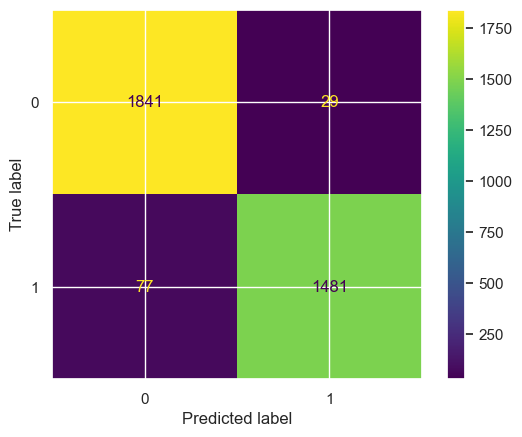

In [102]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)